In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from langchain_community.llms import Ollama
from langgraph.graph import END, Graph
from typing import TypedDict, Dict
import io
import base64


In [ ]:
# Initialize LLM
llm = Ollama(model="llama3.1:8b", temperature=0.3)


C:\Users\R&D\AppData\Local\Temp\ipykernel_22704\2749413207.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.1:8b", temperature=0.3)


In [4]:
# Load and clean data
def load_excel_data(file_path):
    df = pd.read_excel(file_path, sheet_name='Sheet1', header=None)
    headers = [str(col) if not pd.isna(col) else f"unnamed_{i}" 
               for i, col in enumerate(df.iloc[0])]
    df.columns = headers
    df = df.iloc[1:].reset_index(drop=True)
    
    # Convert date columns to proper datetime format
    date_cols = [col for col in df.columns if col.startswith('202')]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    return df

data = load_excel_data("Sales Report.xlsx")

In [5]:
# Plotting tool
def plot_product_sales(state: Dict) -> Dict:
    """Generate a sales plot for the specified product."""
    question = state['question']
    product_name = None
    
    # Extract product name from question
    for product in data['Product Name']:
        if str(product).lower() in question.lower():
            product_name = product
            break
    
    if not product_name:
        return {"result": "Product not found in the data."}
    
    # Get sales data for the product
    product_data = data[data['Product Name'] == product_name]
    if product_data.empty:
        return {"result": "No sales data available for this product."}
    
    # Prepare plot data
    date_cols = [col for col in data.columns if col.startswith('202')]
    sales = product_data[date_cols].iloc[0]
    months = [pd.to_datetime(col).strftime('%b %Y') for col in sales.index]
    
    # Create plot
    plt.figure(figsize=(10, 5))
    plt.plot(months, sales.values, marker='o', linestyle='-')
    plt.title(f"Monthly Sales for {product_name}")
    plt.xlabel("Month")
    plt.ylabel("Sales Amount")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot to bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    
    # Convert to base64 for display in notebook
    plot_base64 = base64.b64encode(buf.read()).decode('utf-8')
    return {
        "result": f"Sales plot generated for {product_name}",
        "plot": f'<img src="data:image/png;base64,{plot_base64}">'
    }


In [6]:
# Define state
class AgentState(TypedDict):
    question: str
    result: str
    plot: str


In [7]:
# Build the graph
workflow = Graph()

workflow.add_node("generate_plot", plot_product_sales)
workflow.add_node("format_response", lambda state: {
    "response": state['result'],
    "plot": state.get('plot', '')
})

workflow.add_edge("generate_plot", "format_response")
workflow.add_edge("format_response", END)
workflow.set_entry_point("generate_plot")

app = workflow.compile()

In [8]:
# Agent runner with plot display
def run_agent(question: str):
    result = app.invoke({"question": question})
    
    # Display in notebook
    from IPython.display import display, HTML
    if result.get('plot'):
        display(HTML(result['plot']))
    return result['response']


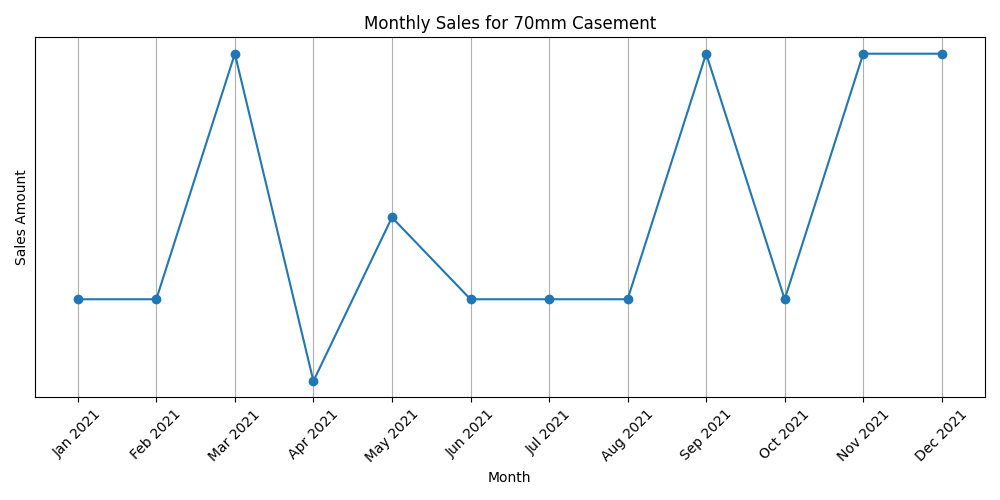

Sales plot generated for 70mm Casement



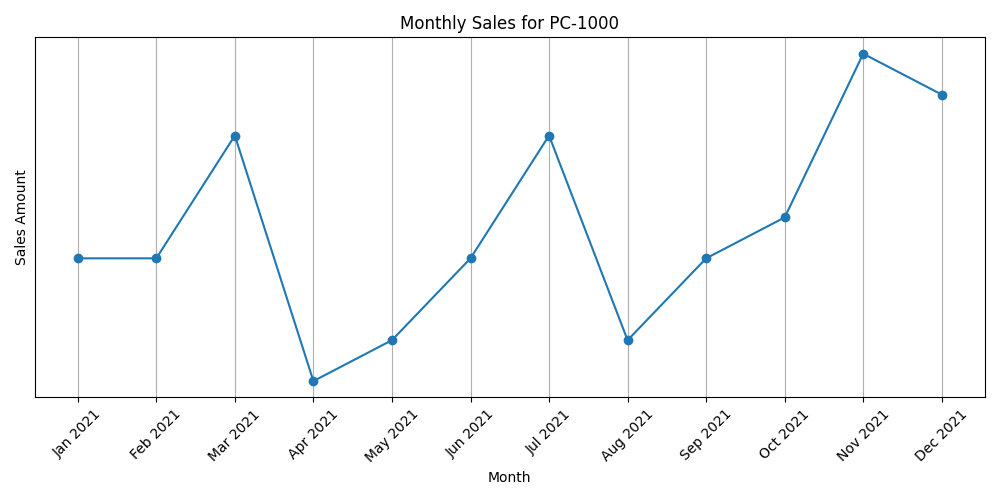

Sales plot generated for PC-1000


In [9]:
# Test the plotting tool
print(run_agent("Show me monthly sales plot for 70mm Casement"))
print(run_agent("Plot sales data for PC-1000"))